Class distribution:
 Fire
1    500
0    500
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7590 - loss: 0.5873 - val_accuracy: 1.0000 - val_loss: 0.4017
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9132 - loss: 0.3957 - val_accuracy: 1.0000 - val_loss: 0.2989
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9557 - loss: 0.3152 - val_accuracy: 1.0000 - val_loss: 0.2253
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9571 - loss: 0.2622 - val_accuracy: 1.0000 - val_loss: 0.1705
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9766 - loss: 0.2141 - val_accuracy: 1.0000 - val_loss: 0.1315
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9925 - loss: 0.1779 - val_accuracy: 1.0000 - val_loss: 0.1031
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9848 - loss: 0.1507 - val_accuracy: 1.0000 - val_loss: 0.0827
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9931 - loss: 0.1208 - val_accuracy: 1.0000 - 

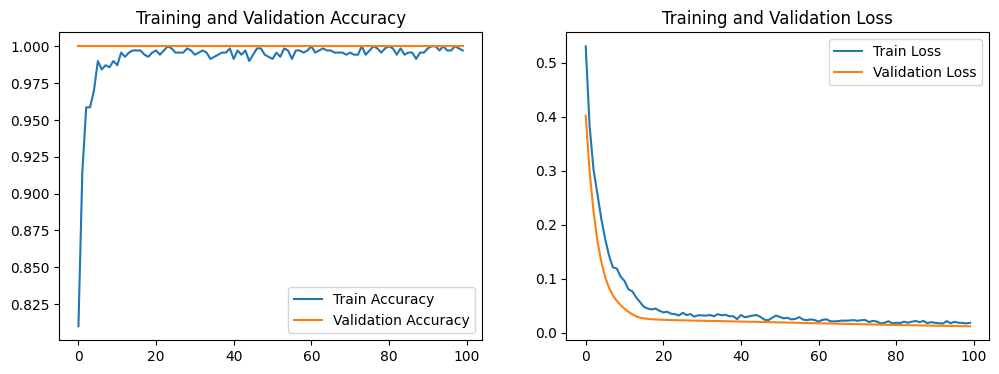

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0116
Test Loss: 0.0116
Test Accuracy: 1.0000

Generalization Gap: -0.0029
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


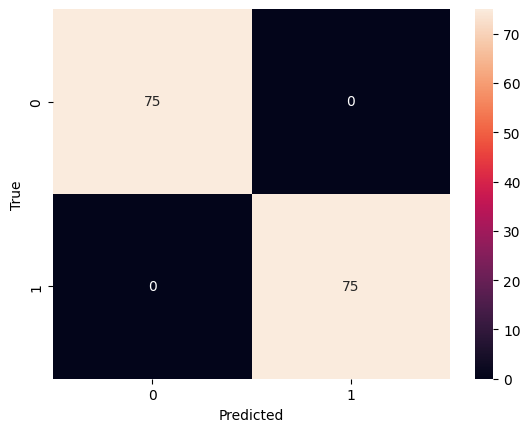

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/content/dataset.csv')


# Check class balance
print("Class distribution:\n", data['Fire'].value_counts())

# Shuffle data (in case of ordered samples)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target
X = data.drop('Fire', axis=1)
y = data['Fire']

# Split data with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Build improved model with regularization
model = keras.Sequential([
    layers.Dense(16, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(8, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

# Train model
history = model.fit(X_train_scaled, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[early_stopping])

# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluate model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Check for overfitting
val_acc = history.history['val_accuracy'][-1]
train_acc = history.history['accuracy'][-1]
print(f"\nGeneralization Gap: {train_acc - val_acc:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()